In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data.
# For example, scale each attribute on the input vector X to [0, 1] or [-1, +1]. e.g. scaler = StandardScaler()
# Finding a reasonable regularization parameter  is best done using GridSearchCV,
# usually in the range 10.0 ** -np.arange(1, 7)
# Empirically, we observed that L-BFGS converges faster and with better solutions on small datasets.
# For relatively large datasets, however, Adam is very robust.

if __name__=='__main__':
    # X : array-like or sparse matrix, shape (n_samples, n_features)
    # y : array-like, shape (n_samples,) or (n_samples, n_outputs)
    X = [[0., 0., 0., 0., 0.], [1., 1., 1., 1., 1.]]
    y = [0, 1]
    
    X_train = [[0., 0., 0., 0., 0.], [1., 1., 1., 1., 1.]]
    X_test = [[0., 0., 0., 0., 0.], [1., 1., 2., 1., 1.]]
    scaler = StandardScaler() 
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) 
    print X_test
    
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X, y)
    print clf.predict([[1., 1., 1., 0., 0.], [0., 0., 0., 0., 1.]])
    print clf.predict_proba([[1., 1., 1., 0., 0.], [0., 0., 0., 0., 1.]])
    print clf.score(X, y)

[[-1. -1. -1. -1. -1.]
 [ 1.  1.  3.  1.  1.]]
[1 0]
[[ 0.10225897  0.89774103]
 [ 0.97116002  0.02883998]]
1.0


In [33]:
# LDA Gibbs sampling
import numpy as np
import random

def rndbias(p):
    if random.random() > p:
        return 1
    else:
        return 0

def samplp(pz):
    res = []
    for p in pz:
        res.append(rndbias(p))
    return res

if __name__=='__main__':
    # Input: words w ∈ documents d
    # words
    w = np.array([0, 1])
    # documents as doc/word matrix
    d = np.array([
        [1, 0],
        [0, 1]
    ])

    # begin randomly initialize z and increment counters
    # z(i) topic index assignment over available topics
    z = np.array([1,1]) # todo: random w/ prior

    # init increment counters
    cdt = np.random.randint(2, size=(2, 2)) # nd,top
    cwt = np.random.randint(2, size=(2, 2)) # nw,top

    N_D = d.shape[0]  # num of docs
    N_W = w.shape[0]  # num of words
    N_K = z.shape[0]  # num of topics

    # Dirichlet priors
    alpha = 0.5
    beta = 0.01

    pz = np.array([0.5, 0.5])

    for niter in range(15):
        # for i = 0 → N −1 do
        nk = N_K
        # for all documents m ∈ [1, M] d
        for d in range(N_D): # documents
            for i in range(N_W): # words
                word = w[i]
                topic = z[i]
                # nd,topic-=1; nword,topic-=1; ntopic-=1
                cdt[d][topic] -= 1 #  the number of words assigned to topic k in document d
                cwt[word][topic] -= 1 # the number of times word w is assigned to topic k
                nk -= 1 # the number of times word w is assigned to topic k
                # for k = 0 → K −1 do
                for k in range(N_K): # topics
                    # p(z = k|·) = (nd,k + αk) nk,w+βw nk+β×W
                    pz[k] = (cdt[d][k] + alpha) * (cwt[i][k] + beta) / (nk + N_W * beta)
                if min(pz)<0:
                    pz += -min(pz)
                pz = pz / sum(pz) # normalize
                # topic ← sample from p(z|·)
                topic = np.random.choice(N_K, p=pz)
                z[i] = topic
                # nd,topic+=1; nword,topic+=1; ntopic+=1
                nk += 1
                cdt[d][topic] += 1
                cwt[word][topic] += 1
    # Output: topic assignments z and counts nd,k,nk,w, and nk
    # return z, nd,k,nk,w,nk
    print pz

[ 0.99019608  0.00980392]


In [16]:
import random
import numpy as np

def rndbias(p):
    if random.random() > p:
        return 1
    else:
        return 0

if __name__=='__main__':
    for i in range(10):
        print rndbias(0.8)
    print np.arange(5)
    print np.random.choice(5, 3, replace=False, p=[0.1, 0, 0.3, 0.6, 0])

0
0
0
0
0
0
1
0
0
0
[0 1 2 3 4]
[3 2 0]


In [17]:
# small LDA example for demo purposes
# example from Probabilistic Topic Models, M Steyvers, T Griths, Handbook of latent semantic analysis 
import random
import math
import time

def poissonrn(lda): # generate a poisson random number
    l = math.exp(-lda)
    k = 1.
    p = random.random()
    while p > l:
        k += 1.
        p *= random.random()
    return (k-1.)

def dirichlet(params): # sample dirichlet distribution
    sample = [random.gammavariate(a,1) for a in params]
    sample = [v/sum(sample) for v in sample]
    return sample

def partsct(doc): # find all parts of a document and count its respective occurance
    chklst = []
    ctlst = []
    for e in doc:
        if not e in chklst:
            chklst.append(e)
            ctlst.append(1)
        else:
            ctlst[chklst.index(e)] += 1
    return (chklst, ctlst)

def topic_parts(ntopics, dbt): # create a topics-part table randomly TODO: add prior distr
    res = [[0 for i in range(len(dbt))] for i in range(ntopics)]
    ie = 0
    for e in dbt:
        for p in e[1]:
            for k in range(p):
                res[random.randint(0,ntopics-1)][ie] += 1
        ie += 1
    return res

def doc_parts_tbl(docs): # build a document-parts table
    ptslst = []
    for d in docs:
        ptslst.append(partsct(d)) 
    return ptslst

def all_parts(dbt): # a list of all parts in all docs, uniquely, from doc parts table
    apts = []
    for d in dbt:
        for de in d[0]:
            if not de in apts:
                apts.append(de)
    return apts

def parts_per_doc(lda): # pick how many parts you want per each composite (doc) - from Poisson distribution
    return poissonrn(lda)

def parts_topics(parts, topics, beta): # build the parts-topics table: for each column draw from Dirichlet distr.(beta)
    res = []
    betalst = []
    for p in parts:
        betalst.append(beta)
    for t in topics:
        res.append(dirichlet(betalst))
    return res

def comp_topics(docs, topics, alpha): # build the composites(docs)-topics table: for each row draw from Dirichlet distr.(alpha)
    res = []
    alphalst = []
    for t in topics:
        alphalst.append(alpha)
    for d in docs:
        res.append(dirichlet(alphalst))
    return res

def smpl_topbydoc(ndoc, doctop): # sample document by topic
    maxtop = 0.
    i = 0
    imax = 0
    for p in doctop[ndoc]:
        if p > maxtop:
            maxtop = p
            imax = i
        i += 1
    return imax

def smpl_partsbytop(ntop, parttop): # sample parts by topic
    maxprt = 0.
    i = 0
    imax = 0
    for p in parttop[ntop]:
        if p > maxprt:
            maxprt = p
            imax = i
        i += 1
    return imax

if __name__=='__main__':
    docs = []
    docs.append('cc')
    docs.append('dd')
    #print docs
    dbt = doc_parts_tbl(docs) # document and parts table
    print dbt
    random.seed(time.clock())
    ntop = 3 # number of topics
    tpparts = topic_parts(ntop, dbt) # randomly assign a topic to each part
    print tpparts
    alpha = 0.2
    beta = 0.5
    #print dirichlet([beta, beta])
    apts = all_parts(dbt) # find all parts making up the documents
    parttop = parts_topics(apts, [0, 1, 2], beta) # create a random parts-topics distribution
    doctop = comp_topics(apts, docs, alpha) # create a random doc-topic distribution
    nthistop = 0
    maxtop = smpl_topbydoc(nthistop, doctop) # sample document by topic
    npt = smpl_partsbytop(maxtop, parttop) # sample parts by topc
    print 'most representative part of doc %d: index %d : part %s' % (nthistop, npt, apts[npt])

[(['c'], [2]), (['d'], [2])]
[[0, 1], [2, 1], [0, 0]]
most representative part of doc 0: index 1 : part d


In [4]:
# https://wiseodd.github.io/techblog/2017/09/07/lda-gibbs/
import numpy as np

# Words
W = np.array([0, 1, 2, 3, 4])

# D := document words
X = np.array([
    [0, 0, 1, 2, 2],
    [0, 0, 1, 1, 1],
    [0, 1, 2, 2, 2],
    [4, 4, 4, 4, 4],
    [3, 3, 4, 4, 4],
    [3, 4, 4, 4, 4]
])

N_D = X.shape[0]  # num of docs
N_W = W.shape[0]  # num of words
N_K = 2  # num of topics

# Dirichlet priors
alpha = 1
gamma = 1

# Z := word topic assignment
Z = np.zeros(shape=[N_D, N_W])

for i in range(N_D):
    for l in range(N_W):
        Z[i, l] = np.random.randint(N_K)  # randomly assign word's topic

# Pi := document topic distribution
Pi = np.zeros([N_D, N_K])

for i in range(N_D):
    Pi[i] = np.random.dirichlet(alpha*np.ones(N_K))

# B := word topic distribution
B = np.zeros([N_K, N_W])

for k in range(N_K):
    B[k] = np.random.dirichlet(gamma*np.ones(N_W))
    
for it in range(1000):
    # Sample from full conditional of Z
    # ---------------------------------
    for i in range(N_D):
        for v in range(N_W):
            # Calculate params for Z
            p_iv = np.exp(np.log(Pi[i]) + np.log(B[:, X[i, v]]))
            p_iv /= np.sum(p_iv)

            # Resample word topic assignment Z
            Z[i, v] = np.random.multinomial(1, p_iv).argmax()

    # Sample from full conditional of Pi
    # ----------------------------------
    for i in range(N_D):
        m = np.zeros(N_K)

        # Gather sufficient statistics
        for k in range(N_K):
            m[k] = np.sum(Z[i] == k)

        # Resample doc topic dist.
        Pi[i, :] = np.random.dirichlet(alpha + m)

    # Sample from full conditional of B
    # ---------------------------------
    for k in range(N_K):
        n = np.zeros(N_W)

        # Gather sufficient statistics
        for v in range(N_W):
            for i in range(N_D):
                for l in range(N_W):
                    n[v] += (X[i, l] == v) and (Z[i, l] == k)

        # Resample word topic dist.
        B[k, :] = np.random.dirichlet(gamma + n)
        
print B

[[ 0.00946214  0.02248632  0.03198897  0.23357924  0.70248334]
 [ 0.16259179  0.39564105  0.35115256  0.00778928  0.08282532]]


In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

def rnd_shelf(nsmpls, nspot, nprod, config):
    X = []
    y = []
    for k in range(nsmpls):
        xs = []
        for i in range(nspot):
            if config == 0:
                if i < nspot/2:
                    xs.append(1.)
                else:
                    xs.append(2.)
        X.append(xs)
        y.append(k % nsmpls)
    return (X, y)

# Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data.
# For example, scale each attribute on the input vector X to [0, 1] or [-1, +1]. e.g. scaler = StandardScaler()
# Finding a reasonable regularization parameter  is best done using GridSearchCV,
# usually in the range 10.0 ** -np.arange(1, 7)
# Empirically, we observed that L-BFGS converges faster and with better solutions on small datasets.
# For relatively large datasets, however, Adam is very robust.

if __name__=='__main__':
    # X : array-like or sparse matrix, shape (n_samples, n_features)
    # y : array-like, shape (n_samples,) or (n_samples, n_outputs)
    #X = [[0., 0., 0., 0., 0.], [1., 1., 1., 1., 1.], [0., 1., 0., 1., 0.]]
    #X = np.random.rand(3,340)
    #y = [0, 1, 0]
    X, y = rnd_shelf(5, 340, 2, 0)
    
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X, y)
    print clf.predict(np.random.rand(1,340))
    print clf.predict_proba(np.random.rand(1,340))
    print clf.score(X, y)

[0]
[[ 0.18755324  0.20018647  0.20241297  0.19396485  0.21588247]]
0.2


In [18]:
# continued fractions and squares
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

def contf(a,b,n):
    if n == 0:
        return [1]
    if a>b:
        d = a // b
    c = a % b
    if c == 1:
        return [d,b]
    return [d, contf(b, c, n-1)]
    
if __name__=='__main__':
    chain = contf(19,4,10)

[4, [1, 3]]


(0, 10)

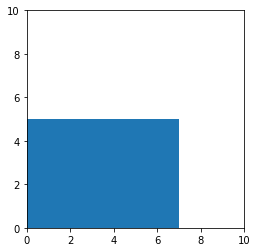

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

a=[0,0]
b=[0,5]
c=[7,0]
d=[7,5]
width = c[0] - a[0]
height = d[1] - a[1]
lims = (0, 10)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.add_patch(
    patches.Rectangle((0, 0), width, height))
plt.ylim(lims)
plt.xlim(lims)

In [3]:
# set test

topicsA = set(["a", "b", "c"])
topicsB = set(["c", "d", "e"])
topicsB.add("f")
topicsB.discard("e")
print topicsA - topicsB # difference
print topicsA | topicsB # union
print topicsA & topicsB # intersection
print len(topicsA)
print topicsA & {'a'}

set(['a', 'b'])
set(['a', 'c', 'b', 'd', 'f'])
set(['c'])
3
set(['a'])


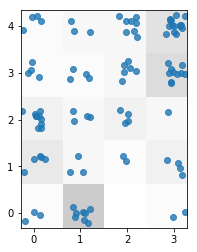

In [50]:
# funny example Gibbs sampler
# from https://stats.stackexchange.com/questions/10213/can-someone-explain-gibbs-sampling-in-very-simple-words
import random
import numpy as np
import matplotlib.pyplot as plt

def accrej(cev): # accept-reject algorithm
    if random.random() > cev:
        return False
    return True

def gibbssampler(condp, niter):
    nrows = len(condp)
    ncols = len(condp[0])
    nevy = random.randint(0,nrows-1) # Choose an attack spell randomly
    nevx = 0
    for itr in range(niter): # Go to step 2, repeat forever
        for i in range(ncols):
            if accrej(condp[nevy][i]): # Use the accept-reject algorithm to choose the buff conditional on the attack
                nevx = i
                break
        for i in range(nrows):
            if accrej(condp[i][nevx]): # Forget the attack spell from step 1, choose a new attack spell using the accept-reject algorithm conditional on the buff in step 2
                nevy = i
                break
    return (nevx, nevy) # Whatever your algorithm has at the last iteration, is your sample

if __name__=='__main__':
    arccybeffstrm = [[0.1, 0.2, 0.2, 0.5],[0.1, 0.1, 0.2, 0.6],[0.3, 0.2, 0.3, 0.2],[0.4, 0.2, 0.1, 0.3],[0.1, 0.8, 0.0, 0.1]]
    #print gibbssampler(arccybeffstrm, 100)
    
    x = []
    y = []
    for r in range(100):
        res = gibbssampler(arccybeffstrm, 10)
        x.append(res[0]+(random.random()/2-0.25))
        y.append(4 - (res[1]+(random.random()/2-0.25)))
    
    extent = np.min(x), np.max(x), np.min(y)-0.1, np.max(y)+0.1
    im1 = plt.imshow(arccybeffstrm, cmap=plt.cm.Greys, alpha=.2, interpolation='nearest', extent=extent)

    plt.scatter(x, y, alpha=0.8)
    plt.show()

In [1]:
# a limit

def limxy(x,y):
    return x*y*y / (x*x + y*y*y*y)

if __name__=='__main__':
    nsteps = 10
    x = 1.
    y = 1.
    dx = x/nsteps
    dy = y/nsteps
    for i in range(nsteps):
        print limxy(x,y)
        x -= dx
        y -= dy
    print 'lim: %f' % (limxy(0.000001, 0.000001))

0.5
0.497237569061
0.487804878049
0.469798657718
0.441176470588
0.4
0.344827586207
0.275229357798
0.192307692308
0.0990099009901
lim: 0.000001


In [4]:
# scammer confusion
import requests
import os
import random
import string
import json

if __name__=='__main__':

    chars = string.ascii_letters + string.digits + '!^§$%&@#*'
    random.seed = (os.urandom(1024))

    url = 'http://wnrplanet.com/'
    names = json.loads(open('names.json').read())

    for name in names:
        name_extra = ''.join(random.choice(string.digits))
        username = name.lower() + name_extra + '@yahoo.com'
        #password = ''.join(random.choice(chars) for i in range(8))

        req = requests.post(url, allow_redirects=False, data={
            'email' : username
        })
        print req.status_code, req.reason

        print 'sending username %s ' % (username)

405 Not Allowed
sending username some2@yahoo.com 
405 Not Allowed
sending username one3@yahoo.com 
405 Not Allowed
sending username henry6@yahoo.com 
405 Not Allowed
sending username lucas0@yahoo.com 
405 Not Allowed
sending username freddy5@yahoo.com 
405 Not Allowed
sending username ergi5@yahoo.com 
405 Not Allowed
sending username blah9@yahoo.com 
405 Not Allowed
sending username meh1@yahoo.com 
405 Not Allowed
sending username you3@yahoo.com 
405 Not Allowed
sending username sabine9@yahoo.com 


In [13]:
# scammer confusion II
import urllib

def scrape(link):
    try:
        headers = {}
        headers['User-Agent'] = "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36"
        return str(urllib.urlopen(urllib.Request(link, headers = headers)).read())
    except Exception as e:
        print(str(e))
        
if __name__=='__main__':
    url = 'http://wnrplanet.com/'
    #print scrape(url)
    f = urllib.urlopen("http://wnrplanet.com/")
    print f.read()

<!DOCTYPE HTML>
<!--
	
-->
<html>
	<head>
		<title>Infra IT Systems</title>
		<meta charset="utf-8" />
		<meta name="viewport" content="width=device-width, initial-scale=1, user-scalable=no" />
		<!--[if lte IE 8]><script src="assets/js/ie/html5shiv.js"></script><![endif]-->
		<link rel="stylesheet" href="assets/css/main.css" />
		<!--[if lte IE 8]><link rel="stylesheet" href="assets/css/ie8.css" /><![endif]-->
		<!--[if lte IE 9]><link rel="stylesheet" href="assets/css/ie9.css" /><![endif]-->
	</head>
	<body>

		<!-- Header -->
			<header id="header">
				<h1>Infra IT Systems</h1>
				<p>A simple technological solution for small business.<br />
				Please leave us your email and we will get back to you.
			</p>
			</header>

		<!-- Signup Form -->
			<form id="signup-form" method="post" action="#">
				<input type="email" name="email" id="email" placeholder="Email Address" />
				<input type="submit" value="Sign Up" />
			</form>

		<!-- Footer -->
			<footer id="footer">
				<ul clas

In [5]:
# access via scripting - get mouse position
import pyautogui
import time

if __name__=='__main__':
    pyautogui.PAUSE = 1
    pyautogui.FAILSAFE = True
    time.sleep(3)
    print pyautogui.position()

Point(x=404, y=637)


In [10]:
# access via scripting test 0
import pyautogui
import pyperclip
import time

if __name__=='__main__':
    pyautogui.PAUSE = 1
    pyautogui.FAILSAFE = True

    pyautogui.moveTo(101, 635)
    time.sleep(0.1)
    pyautogui.click(101, 635)
    time.sleep(0.1)
    pyautogui.typewrite('freddy8')
    #pyautogui.press(u'@')
    pyperclip.copy("@")
    pyautogui.hotkey("ctrl", "v")
    pyautogui.typewrite('yahoo.com')
    time.sleep(0.1)
    pyautogui.moveTo(404, 635)
    time.sleep(0.1)
    pyautogui.click(404, 635)
    

In [11]:
# access via scripting test 0
import pyautogui
import pyperclip
import time
import os
import random
import string
import json

if __name__=='__main__':
    pyautogui.PAUSE = 1
    pyautogui.FAILSAFE = True
    
    chars = string.ascii_letters + string.digits + '!^§$%&@#*'
    random.seed = (os.urandom(1024))

    #url = 'http://wnrplanet.com/'
    names = json.loads(open('names.json').read())

    for name in names:
        name_extra = ''.join(random.choice(string.digits))
        username = name.lower() + name_extra + '@yahoo.com'

        pyautogui.moveTo(101, 635)
        time.sleep(0.1)
        pyautogui.click(101, 635)
        time.sleep(0.1)
        pyautogui.typewrite(name.lower() + name_extra)
        #pyautogui.press(u'@')
        pyperclip.copy("@")
        pyautogui.hotkey("ctrl", "v")
        pyautogui.typewrite('yahoo.com')
        time.sleep(0.1)
        pyautogui.moveTo(404, 635)
        time.sleep(0.1)
        pyautogui.click(404, 635)
        
        print 'sending username %s ' % (username)
        time.sleep(0.2)

sending username some1@yahoo.com 
sending username one5@yahoo.com 
sending username henry4@yahoo.com 
sending username lucas0@yahoo.com 
sending username freddy7@yahoo.com 
sending username ergi0@yahoo.com 
sending username blah2@yahoo.com 
sending username meh0@yahoo.com 
sending username you8@yahoo.com 
sending username sabine4@yahoo.com 


In [6]:

def mw(lst):
    zahl = 0
    for i in lst:
        zahl = zahl + i
    erg = zahl/len(lst)
    return erg

if __name__=='__main__':
    packilist = [1,2,3]
    print mw(packilist)

2


In [22]:
# left factorials

def fact(n):
    if n == 0:
        return 1
    res = 1
    for k in range(1,n+1):
        res *= k
    return res

def lfact(n):
    if n == 0:
        return 1
    res = 0
    for k in range(n):
        res += fact(k)
    return res    

if __name__=='__main__':
    print lfact(5)

34


In [26]:
# Stern-Brocot sequence

def sternbronxt(cons, prec):
    return [cons + prec, cons]

def sternbro(n):
    res = [1, 1]
    for k in range(n):
        thisres = sternbronxt(res[k+1], res[k])
        res.append(thisres[0])
        res.append(thisres[1])
    return res

if __name__=='__main__':
    print sternbro(5)

[1, 1, 2, 1, 3, 2, 3, 1, 4, 3, 5, 2]


In [11]:
# reversing digits

def lasttofirst(n):
    digstr = str(n)
    ln = len(digstr)
    digstr = digstr[ln-1] + digstr
    return int(digstr[:ln])

if __name__=='__main__':
    #print lasttofirst(152)
    for n in range(105263157894000000,105263157895000000):
        if 2*n == lasttofirst(n):
            print n

105263157894736842


In [13]:
from PIL import Image
import random
import math
 
def generate_voronoi_diagram(width, height, num_cells):
	image = Image.new("RGB", (width, height))
	putpixel = image.putpixel
	imgx, imgy = image.size
	nx = []
	ny = []
	nr = []
	ng = []
	nb = []
	for i in range(num_cells):
		nx.append(random.randrange(imgx))
		ny.append(random.randrange(imgy))
		nr.append(random.randrange(256))
		ng.append(random.randrange(256))
		nb.append(random.randrange(256))
	for y in range(imgy):
		for x in range(imgx):
			dmin = math.hypot(imgx-1, imgy-1)
			j = -1
			for i in range(num_cells):
				d = math.hypot(nx[i]-x, ny[i]-y)
				if d < dmin:
					dmin = d
					j = i
			putpixel((x, y), (nr[j], ng[j], nb[j]))
	image.save("VoronoiDiagram.png", "PNG")
        image.show()
 
generate_voronoi_diagram(500, 500, 25)

In [18]:
# Miller–Rabin primality test
import random

def mira(n, k):
#Input: n > 2, an odd integer to be tested for primality;
#       k, a parameter that determines the accuracy of the test
#Output: composite if n is composite, otherwise probably prime
    if n%2 == 0 or n<3:
        return n
    # write n − 1 as 2^s·d with d odd by factoring powers of 2 from n − 1
    d = n - 1
    s = 0
    while d % 2 == 0:
        s += 1
        d /= 2
    for ik in range(k):
        a = random.randint(2, n-1)
        x = (a**d) % n
        if x == 1 or x == (n-1):
            continue
        for r in range(1, s-1):
            x = (x**2) % n
            if x==1:
                return 'composite'
        if x==(n-1):
            continue
        return 'composite'
    return 'probably prime'

if __name__=='__main__':
    print mira(15, 3)

composite
